# License Plate Recognition
License Plate Recognition Algorithm

1. License Plate Detection:
    - [Contour Detection](#Contour-Detection)
    - [Haar Cascade](#Car-Plate-Detection-with-OpenCV-and-Haar-Cascade-feature-set)
2. Character Segmentation:
3. Character Recognition:
    -  [OCR (Optical Character Recognition) with Pytesseract](#Car-Plate-Number-Optical-Character-Recognition(OCR)-with-Pytesseract)

In [89]:
import cv2
import imutils
import numpy as np
import pytesseract

from PIL import Image
from pytesseract import Output
import requests
from IPython.display import display

In [90]:
pytesseract.pytesseract.tesseract_cmd = r'D:\Program Files\Tesseract-OCR\tesseract.exe'

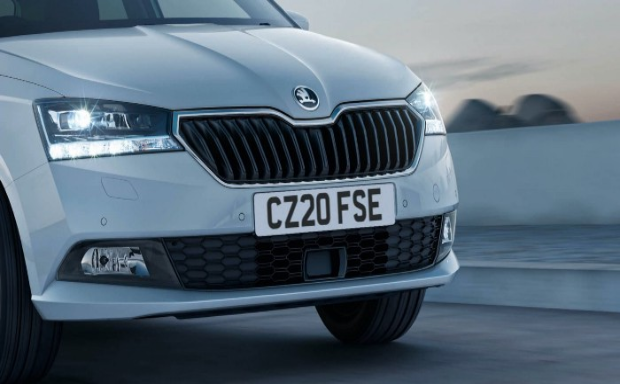

In [91]:
img = cv2.imread('license-plate/Plate5.jpg',cv2.IMREAD_COLOR)
img = cv2.resize(img, (620,384) )
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
display(Image.fromarray(rgb_img))

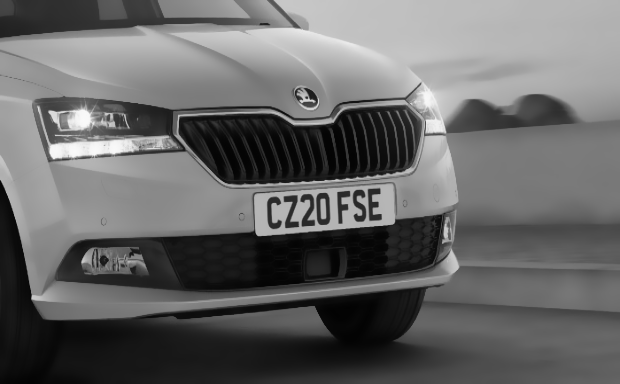

In [92]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
# bilateral filter (Blurring) will remove the unwanted details from an image
# destination_image = cv2.bilateralFilter(source_image, diameter of pixel, sigmaColor, sigmaSpace)
gray = cv2.bilateralFilter(gray, 13, 15, 15) 
display(Image.fromarray(gray))

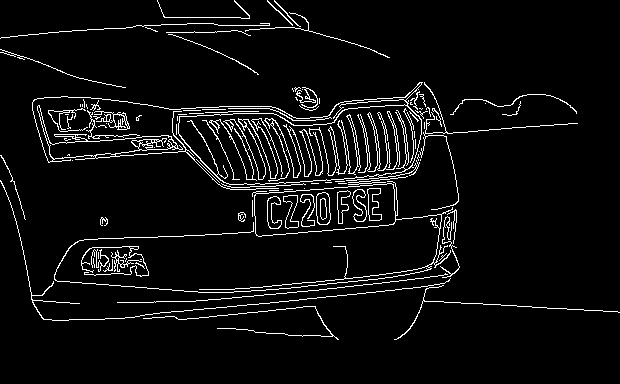

In [93]:
# edge detection
edged = cv2.Canny(gray, 30, 200) 
display(Image.fromarray(edged))

## Contour Detection

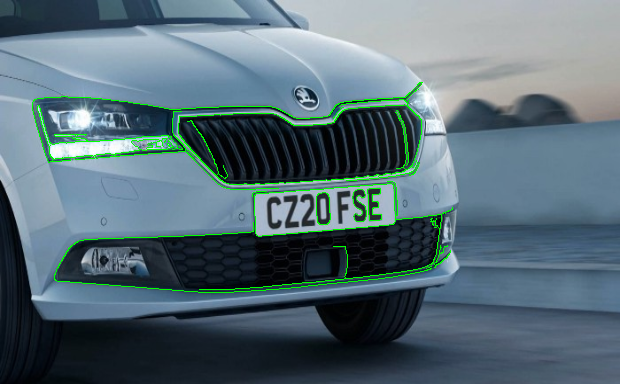

7
6
9
4


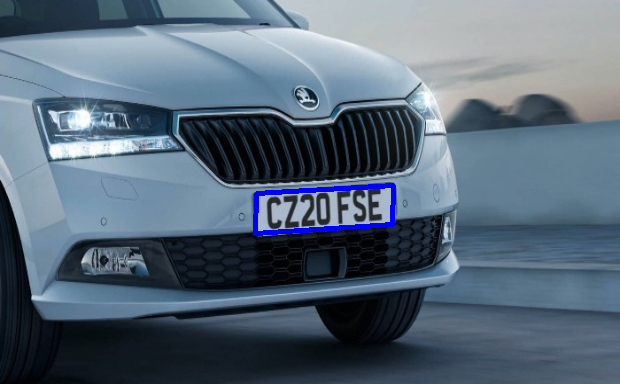

7
8
8
12
12
14


In [94]:
# contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours=cv2.findContours(edged.copy(),cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contours = imutils.grab_contours(contours)
contours = sorted(contours,key=cv2.contourArea, reverse = True)[:10]
screenCnt = None

img = rgb_img.copy()
cv2.drawContours(img, contours, -1, (0,255,0), 1)
display(Image.fromarray(img))

screenCnt = None
for c in contours:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.018 * peri, True)
    print(len(approx))
    img = rgb_img.copy()
    if len(approx) == 4:
        screenCnt = approx
        cv2.drawContours(img, [screenCnt], -1, (0, 0, 255), 3)
        display(Image.fromarray(img))

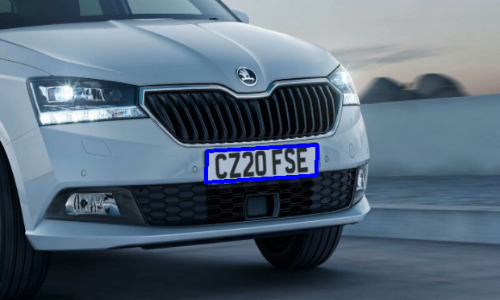

In [95]:
if screenCnt is None:
    print ("No contour detected")
else:
    cv2.drawContours(img, [screenCnt], -1, (0, 0, 255), 3)
    img_resize = cv2.resize(img,(500,300))
    display(Image.fromarray(img_resize))
    

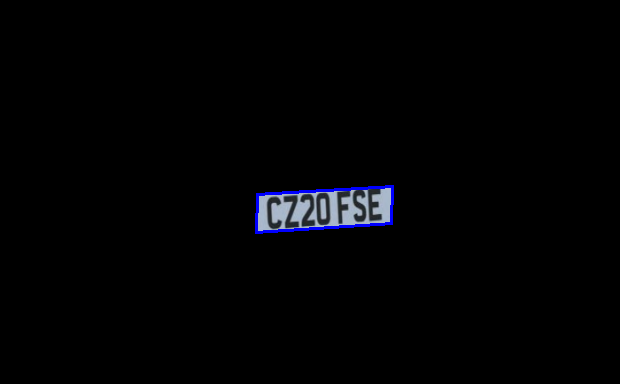

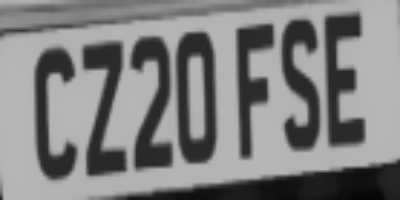

In [96]:
if screenCnt is None:
    print ("No contour detected")
else:
    mask = np.zeros(gray.shape,np.uint8) # character segmentation
    new_image = cv2.drawContours(mask,[screenCnt],0,255,-1,)
    new_image = cv2.bitwise_and(img,img,mask=mask)
    display(Image.fromarray(new_image))
    
    
    (x, y) = np.where(mask == 255)
    (topx, topy) = (np.min(x), np.min(y))
    (bottomx, bottomy) = (np.max(x), np.max(y))
    cropped = gray[topx:bottomx+1, topy:bottomy+1]

    

    cropped_resize = cv2.resize(cropped,(400,200))
    display(Image.fromarray(cropped_resize))

## Car Plate Number Optical Character Recognition(OCR) with Pytesseract

In [97]:
if screenCnt is None:
    print ("No contour detected")
else:
    text = pytesseract.image_to_string(cropped, config='--psm 11')
    print("Detected license plate Number is:",text)

Detected license plate Number is: CZ20FSE



## Car Plate Detection with OpenCV and Haar Cascade feature set

[Haar Cascades](https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/viola-cvpr-01.pdf), a machine learning based object detection algorithm, proposed by Paul Viola and Michael Jones, which uses Haar features to determine the likelihood of a certain point being part of an object. 

In [98]:
import os.path
from os import path

if not path.exists("haarcascade_russian_plate_number.xml"):
    url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_russian_plate_number.xml"
    response = requests.get(url)
    with open("haarcascade_russian_plate_number.xml", "wb") as f:
        f.write(response.content)
carplate_haar_cascade = cv2.CascadeClassifier('haarcascade_russian_plate_number.xml')

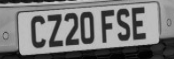

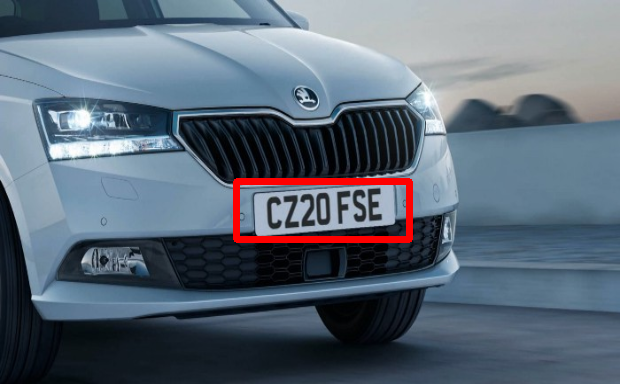

In [112]:
# Setup function to detect car plate
gray = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY) 
carplate_overlay = rgb_img.copy() 
carplate_rects = carplate_haar_cascade.detectMultiScale(gray,scaleFactor=1.1, minNeighbors=11)
cropped = []
for x,y,w,h in carplate_rects: 
#     print(x,y,w,h)
    cv2.rectangle(carplate_overlay, (x,y), (x+w,y+h), (255,0,0), 5) 
    cropped.append(gray[y:y+h+1, x:x+w+1])
#     ret,cropped = cv2.threshold(cropped,127,255,cv2.THRESH_BINARY)
    display(Image.fromarray(gray[y:y+h+1, x:x+w+1]))

detected_carplate_img = carplate_overlay

display(Image.fromarray(detected_carplate_img))

In [113]:
for crop in cropped:
    text = pytesseract.image_to_string(crop, config='--psm 13 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    print("Detected license plate Number is:",text)

Detected license plate Number is: CZ20FSE



## Bluring the detected plate

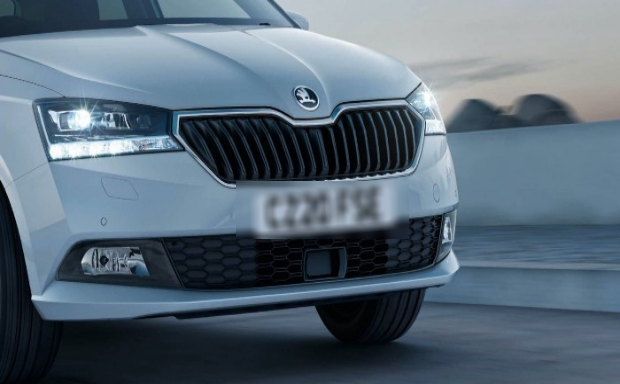

In [114]:
plate_img = rgb_img.copy()
roi = rgb_img.copy()

plate_rects = carplate_haar_cascade.detectMultiScale(plate_img,scaleFactor=1.1, minNeighbors=11) 

for (x,y,w,h) in plate_rects: 

    roi = roi[y:y+h,x:x+w]
    blurred_roi = cv2.medianBlur(roi,7)
    blurred_roi = cv2.blur(blurred_roi,(11,11))
    

    plate_img[y:y+h,x:x+w] = blurred_roi

display(Image.fromarray(plate_img))

## Testing 

In [116]:

carplate_haar_cascade = cv2.CascadeClassifier('haarcascade_russian_plate_number.xml')

def test_carplate_number(img_rgb, actual_carplate_number): 
#     img_blur = cv2.blur(src=img_rgb, ksize=(5,5))
    
    img_gray = cv2.cvtColor(img_rgb,cv2.COLOR_RGB2GRAY)
    
    img_gray_eq = cv2.equalizeHist(img_gray)
    img_blur = cv2.blur(img_gray, (3,3))
#     img_blur =  cv2.bilateralFilter(src=img_gray_eq, d=3, sigmaColor=75, sigmaSpace=75)
#     kernel = np.ones((3,3),np.uint8)
#     opening = cv2.morphologyEx(img_gray_eq, cv2.MORPH_OPEN, kernel)
#     edges = cv2.Canny(image=img_blur, threshold1=0, threshold2=255)
    
    
    carplate_overlay = img_rgb.copy() 
    
    
    
    carplate_rects = carplate_haar_cascade.detectMultiScale(img_blur,scaleFactor=1.05, minNeighbors=6)
    
    if len(carplate_rects) == 0:
        print("******* No carplate detected for car plate number", actual_carplate_number)
        return
    for x,y,w,h in carplate_rects: 
    #     print(x,y,w,h)
        
        cropped = img_rgb[y:y+h+1, x:x+w+1]
        
        cropped_gray = cv2.cvtColor(cropped, cv2.COLOR_RGB2GRAY)
        
        text = pytesseract.image_to_string(cropped_gray, config='--psm 13 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
#         text = pytesseract.image_to_string(cropped_gray, config='--psm 11 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
        
    
        rand = np.random.randint(255, size=3)
        cv2.rectangle(carplate_overlay, (x,y), (x+w+1,y+h+1), (255,0,0), 5) 
        text = text.replace("\n", " ")

        print("Detected license plate Number is:", text)
#         display(Image.fromarray(cropped))
    print("Actual license plate Number is:", actual_carplate_number)

    detected_carplate_img = carplate_overlay

#     display(Image.fromarray(detected_carplate_img))
#     

# W4614W
    
    
actual_carplate_number_list = ['UTM9999','YA8055','QAA1989C', 'IM4U555', 'CZ20FSE', 'WA688M']    
for i in range(1,len(actual_carplate_number_list)+1):
    img = cv2.imread('license-plate/Plate'+str(i)+'.jpg')

    img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#     img_rgb = cv2.resize(img_rgb, (512,512))
    actual_carplate_number = actual_carplate_number_list[i-1]
    test_carplate_number(img_rgb, actual_carplate_number)

Detected license plate Number is: UTM9999 
Detected license plate Number is: 
Detected license plate Number is: UTM 
Actual license plate Number is: UTM9999
Detected license plate Number is: YA8055 
Detected license plate Number is: SS 
Detected license plate Number is: 
Actual license plate Number is: YA8055
Detected license plate Number is: QAAIS89C 
Detected license plate Number is: TC 
Detected license plate Number is: 
Detected license plate Number is: 
Actual license plate Number is: QAA1989C
Detected license plate Number is: IM4555 
Detected license plate Number is: M 
Detected license plate Number is: OE 
Actual license plate Number is: IM4U555
Detected license plate Number is: CZ20FSE 
Actual license plate Number is: CZ20FSE
Detected license plate Number is: WA688M 
Actual license plate Number is: WA688M


The performance is fast but the accuracy of this detection may be low and high false positive rate. Fine Tuning the preprocessing step and Haarcascade.detectMultiScale() parameter might improve the accuracy suitable for the particular application. The sample images with low resolutions and or non rusian plate and or side view may not be suitable or applicable.
Create your own feature by training a feature suited for your project may work better than reusing similar cascade feature. 
This is merely showing the effectiveness of the cascade clasifier.